In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

from modules import optimize_null, forward_simulation
from modules.elbo import ELBO

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'carlos'
category = 'synthetic'
eccentricity = 'fovea'
movie_id = 4
dat_movie_name = 'EGOMOTION'   # movie name as in the data file name
stim_movie_name = 'egomotion' # movie name as in the stimulus file name
n_bootstraps = 1

match eccentricity:
    case 'fovea':
        diameter = 6
    case 'parafovea':
        diameter = 24
    case _:
        diameter = 36

dat = torch.load(Path('data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
# dat = torch.load(Path('data') / 'behavioral_data_09052025' / 'pt' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

prob_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Compute null model

In [4]:
is_natural = True if category == 'natural' else False
    
# n_dim = n_frames - 1
n_dim = 5
version = 2
x_null, c_pixel, c_null, prob_corr_human, prob_corr_null = optimize_null(stim_folder, n_corr_obs, n_total_obs, n_dim=n_dim, n_starts=10, n_iter=20000, n_frames=n_frames, is_natural=is_natural, version=version, disp=False)

Running MLE to initialize posterior..........................
Current loss: 373.0120152235031
Loss updated
Iteration 1 | Loss: 373.0120152235031
Current loss: 345.4013003408909
Loss updated
Iteration 2 | Loss: 345.4013003408909
Current loss: 343.3095013126731
Loss updated
Iteration 3 | Loss: 343.3095013126731
Current loss: 339.2671234831214
Loss updated
Iteration 4 | Loss: 339.2671234831214
Current loss: 341.65063339471817
Iteration 5 | Loss: 341.65063339471817
Current loss: 336.937929905951
Loss updated
Iteration 6 | Loss: 336.937929905951
Current loss: 360.64321594685316
Iteration 7 | Loss: 360.64321594685316
Current loss: 354.5975628569722
Iteration 8 | Loss: 354.5975628569722
Current loss: 347.07889503240585
Iteration 9 | Loss: 347.07889503240585
Current loss: 347.9974384456873
Iteration 10 | Loss: 347.9974384456873
Epoch: 0, Loss: 821.2119478135987
Epoch: 250, Loss: 676.4581166917183
Epoch: 500, Loss: 598.1238192163237
Epoch: 750, Loss: 548.9562663043139
Epoch: 1000, Loss: 517.164

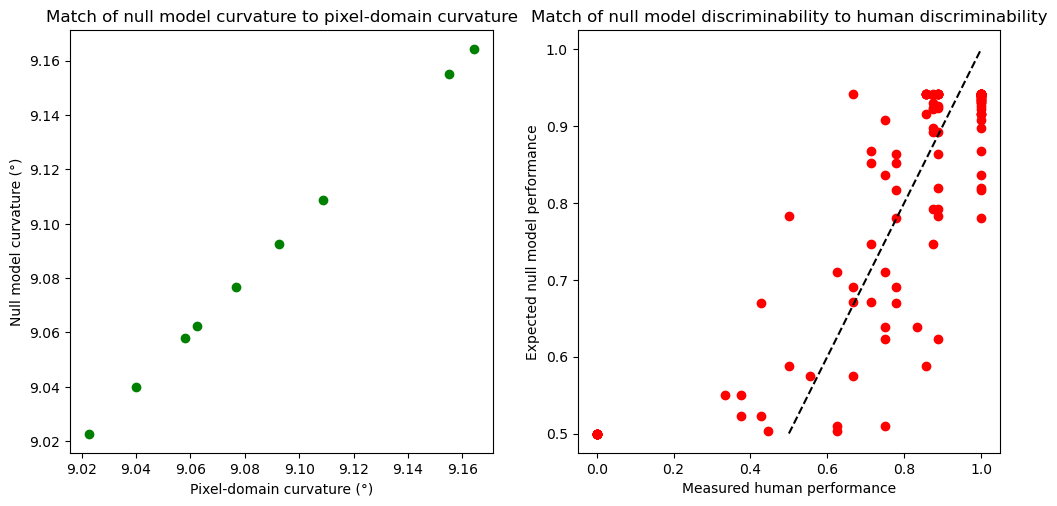

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].plot(np.rad2deg(c_pixel.detach().numpy()), np.rad2deg(c_null.detach().numpy()), 'go')
# axs[0, 0].plot([0.5, 1], [0.5, 1], 'k--')
axs[0].set_title('Match of null model curvature to pixel-domain curvature')
axs[0].set_xlabel('Pixel-domain curvature (°)')
axs[0].set_ylabel('Null model curvature (°)')
axs[0].set_box_aspect(1)

axs[1].plot(prob_corr_human.flatten(), prob_corr_null.flatten().detach(), 'ro')
axs[1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1].set_title('Match of null model discriminability to human discriminability')
axs[1].set_xlabel('Measured human performance')
axs[1].set_ylabel('Expected null model performance')
axs[1].set_box_aspect(1)

### Synthesize data from null model observer

In [6]:
# n_reps = int(np.max(n_total_obs))
n_reps = 10
prob_corr_null_sim, n_total_obs_null_sim = forward_simulation(x_null.detach().squeeze(), n_reps, var = 1)

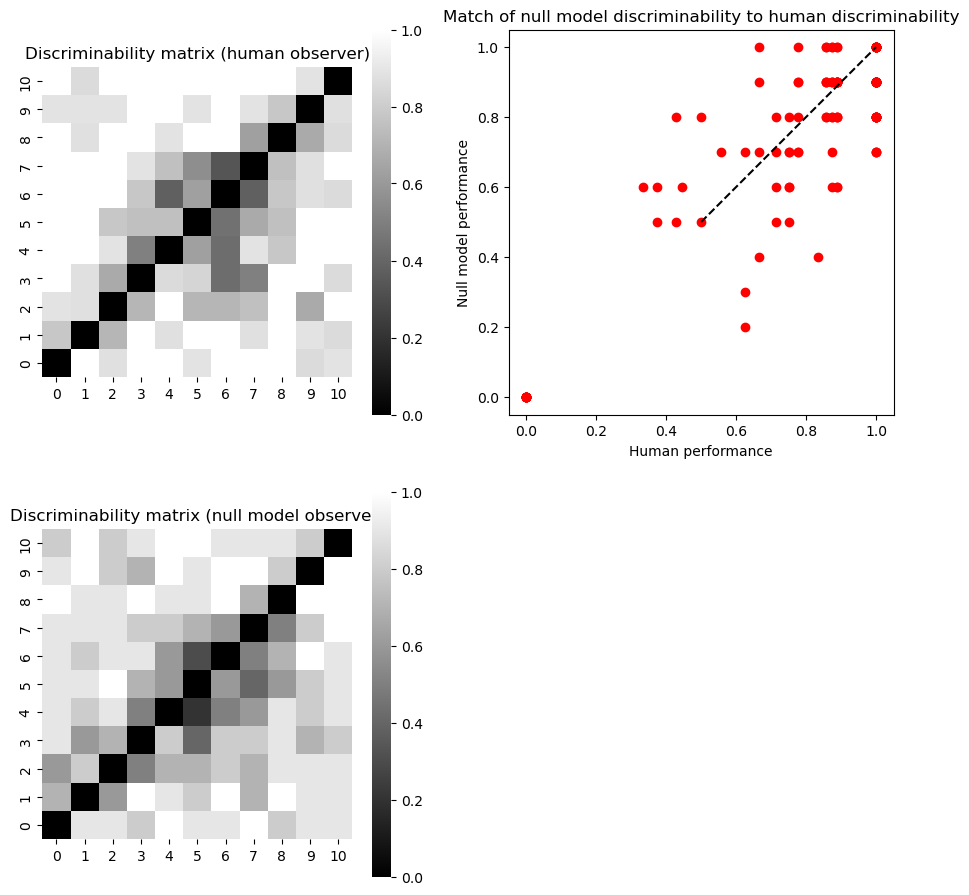

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix (human observer)')
axs[0, 0].set_box_aspect(1)

sns.heatmap(prob_corr_null_sim, ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Discriminability matrix (null model observer)')
axs[1, 0].set_box_aspect(1)

axs[0, 1].plot(prob_corr_human.flatten(), prob_corr_null_sim.flatten(), 'ro')
axs[0, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[0, 1].set_title('Match of null model discriminability to human discriminability')
axs[0, 1].set_xlabel('Human performance')
axs[0, 1].set_ylabel('Null model performance')
axs[0, 1].set_box_aspect(1)

axs[1, 1].set_axis_off()

### Run optimization on simulated data from null model

In [8]:
n_corr_obs_null = np.round(n_total_obs_null_sim * prob_corr_null_sim)

elbo_null = ELBO(n_dim, n_corr_obs_null, n_total_obs_null_sim, n_starts=10, n_iterations=40000)
x_null_elbo, p_null_elbo, errors_null_elbo, kl_loss_null, ll_loss_null, c_prior_null, d_prior_null, l_prior_null, c_post_null, d_post_null, l_post_null, c_est_null = elbo_null.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 426.4451372474432
Loss updated
Iteration 1 | Loss: 426.4451372474432
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 2 | Loss: 408.2060782536864
Current loss: 405.57612527161837
Loss updated
Iteration 3 | Loss: 405.57612527161837
Current loss: 399.8386742025614
Loss updated
Iteration 4 | Loss: 399.8386742025614
Current loss: 415.9483972042799
Iteration 5 | Loss: 415.9483972042799
Current loss: 398.9806092604995
Loss updated
Iteration 6 | Loss: 398.9806092604995
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 7 | Loss: 419.81535140424967
Current loss: 398.1854327991605
Loss updated
Iteration 8 | Loss: 398.1854327991605
Current loss: 407.21291545033455
Iteration 9 | Loss: 407.21291545033455
Current loss: 393.0509441792965
Loss updated
Iteration 10 | Loss: 393.0509441792965
Epoch: 0, Loss: 3954.557973650716
Epoch: 250, Loss: 2030.1532428894673
Epoch: 500, Loss: 1511.7773923490665
Epoch: 750, Loss: 1246.721856066676
Epoch: 1000,

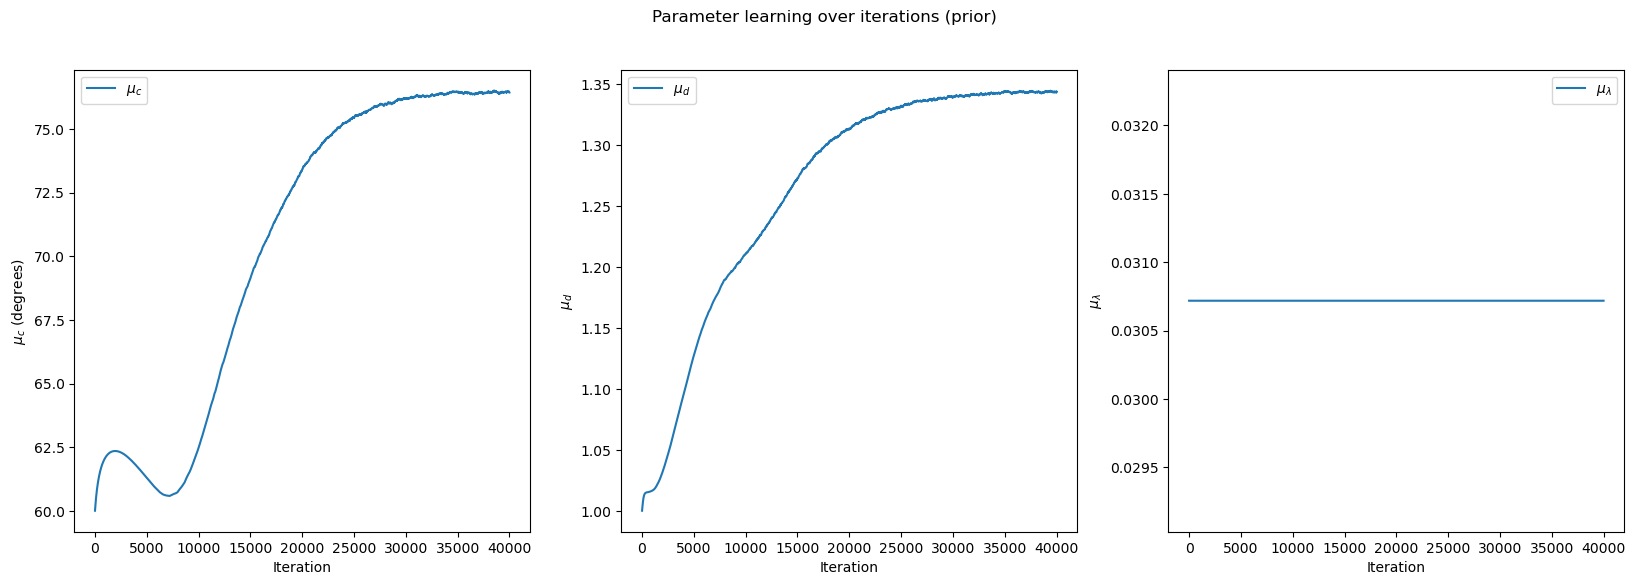

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior_null, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior_null, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior_null, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

/var/folders/_c/tp58p8fd4t51w6w34tsknzpw0000gr/T/ipykernel_2858/2674834642.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axs[2].plot(l_post_null.T)


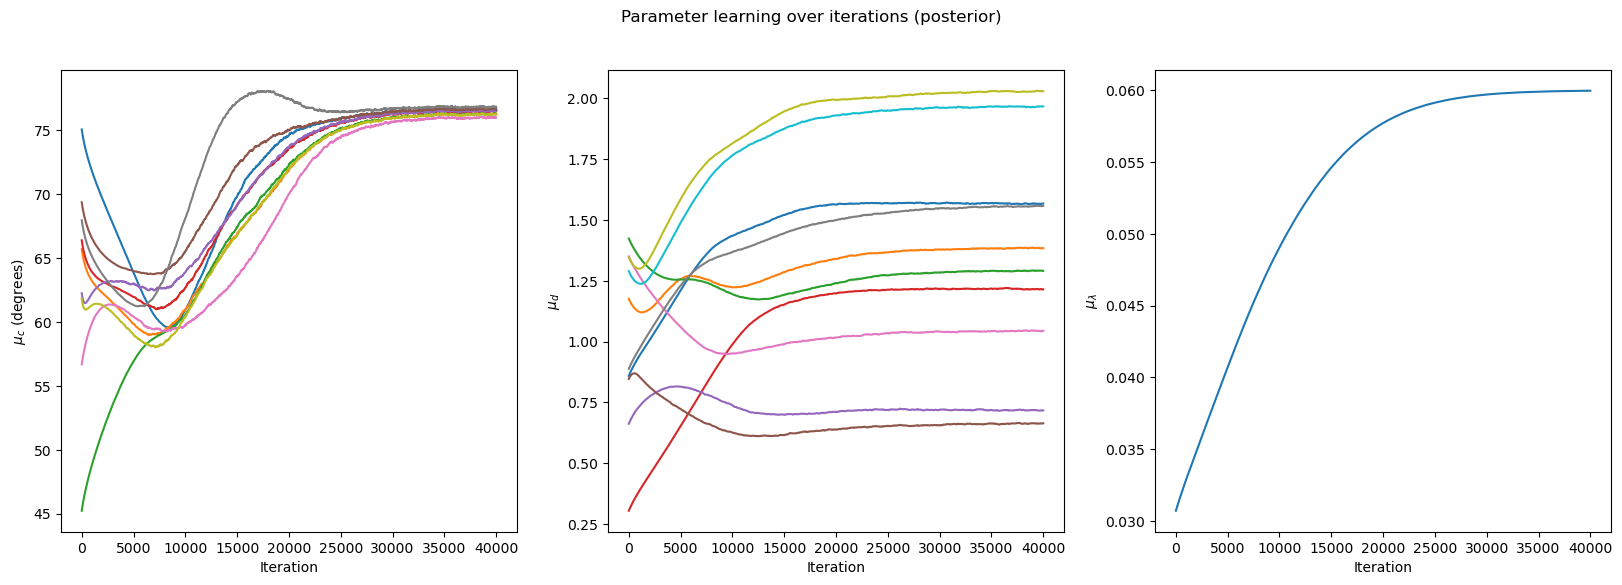

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post_null.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post_null.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post_null.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [11]:
est_global_curvature_null = torch.rad2deg(elbo_null.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature_null} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo_null.mu_post_c).detach())} degrees')

Estimated global curvature: 76.43080139160156 degrees
Average estimated local curvature: 76.43133983898964 degrees


### Run optimization on real data

In [12]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=40000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 1 | Loss: 331.9333633556962
Current loss: 333.8827166967094
Loss updated
Iteration 2 | Loss: 333.8827166967094
Current loss: 357.27322118729353
Iteration 3 | Loss: 357.27322118729353
Current loss: 332.7808658890426
Loss updated
Iteration 4 | Loss: 332.7808658890426
Current loss: 362.0601667314768
Iteration 5 | Loss: 362.0601667314768
Current loss: 347.99824396520853
Iteration 6 | Loss: 347.99824396520853
Current loss: 335.78497342020273
Iteration 7 | Loss: 335.78497342020273
Current loss: 340.33031571656466
Iteration 8 | Loss: 340.33031571656466
Current loss: 344.1233014985919
Iteration 9 | Loss: 344.1233014985919
Current loss: 399.56505589187145
Iteration 10 | Loss: 399.56505589187145
Epoch: 0, Loss: 427.99982966190805
Epoch: 250, Loss: 417.380162466257
Epoch: 500, Loss: 414.0100473171075
Epoch: 750, Loss: 406.6285628592913
Epoch: 1000, Loss: 402.2388906183189
Epoch: 1250, Loss: 397.

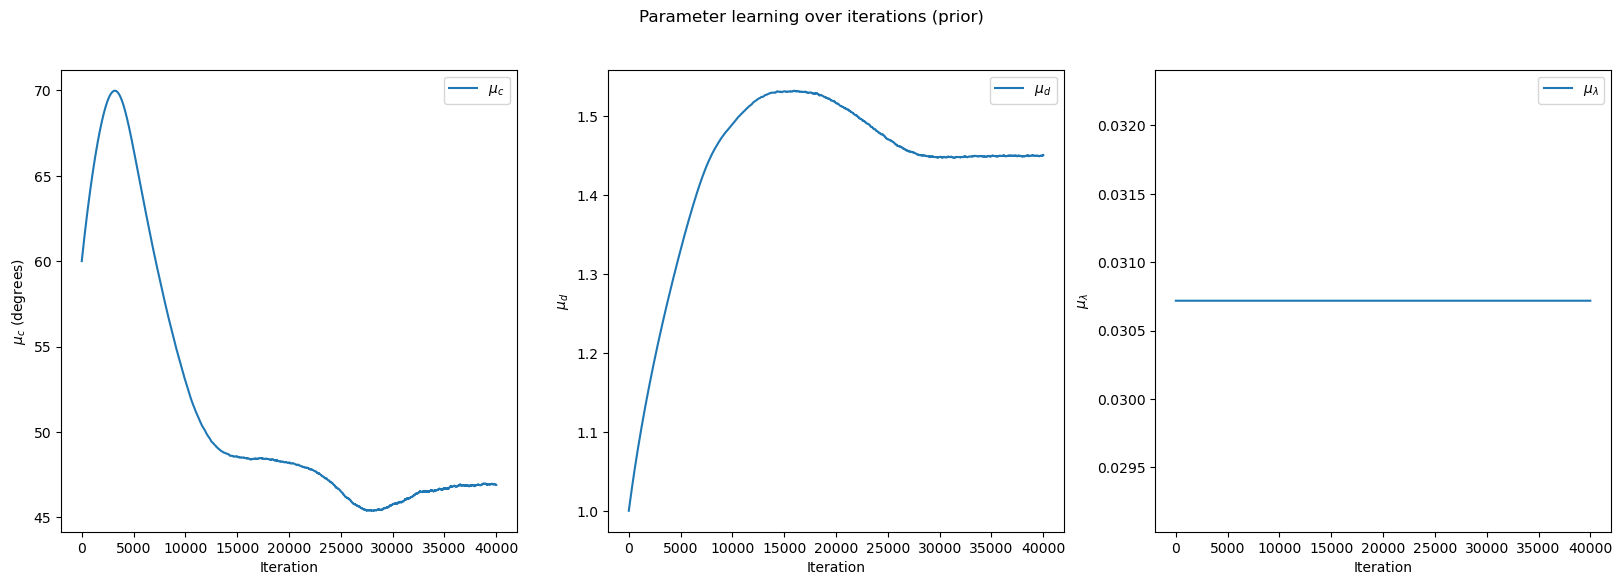

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

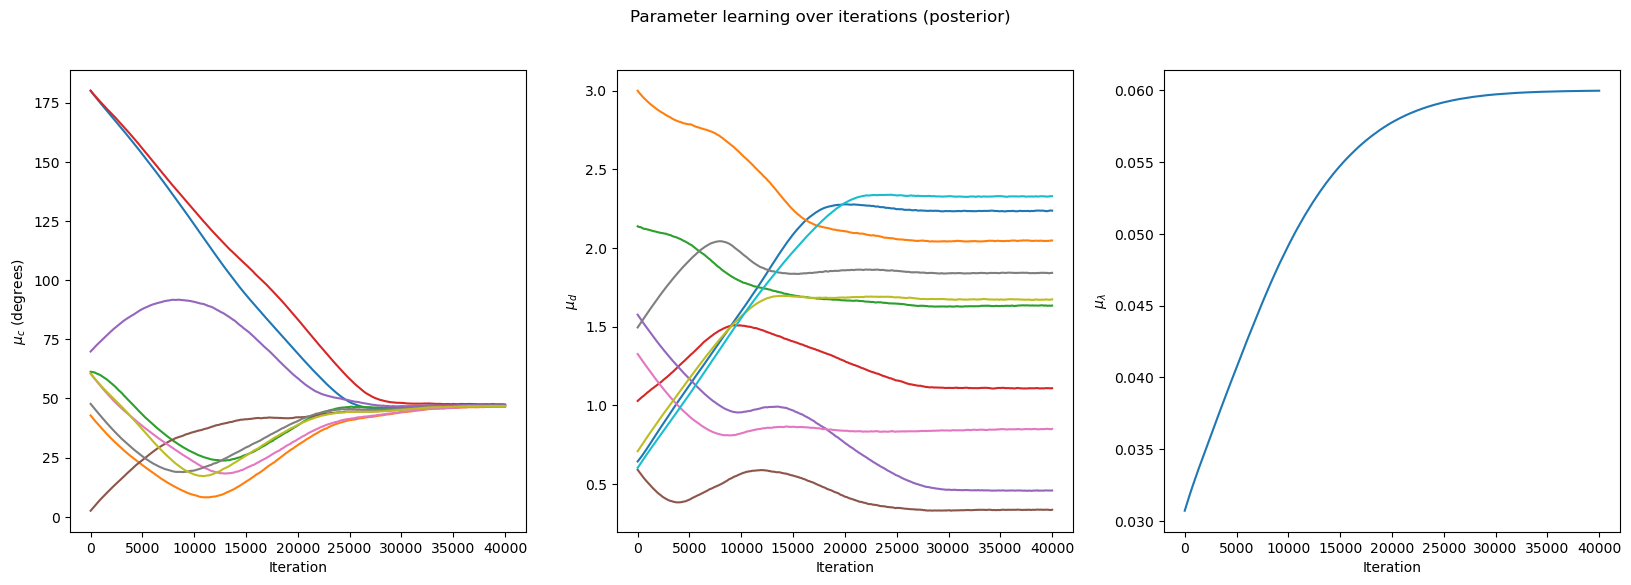

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [15]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 46.88813018798828 degrees
Average estimated local curvature: 46.88691877135623 degrees


### Analyze results

In [16]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

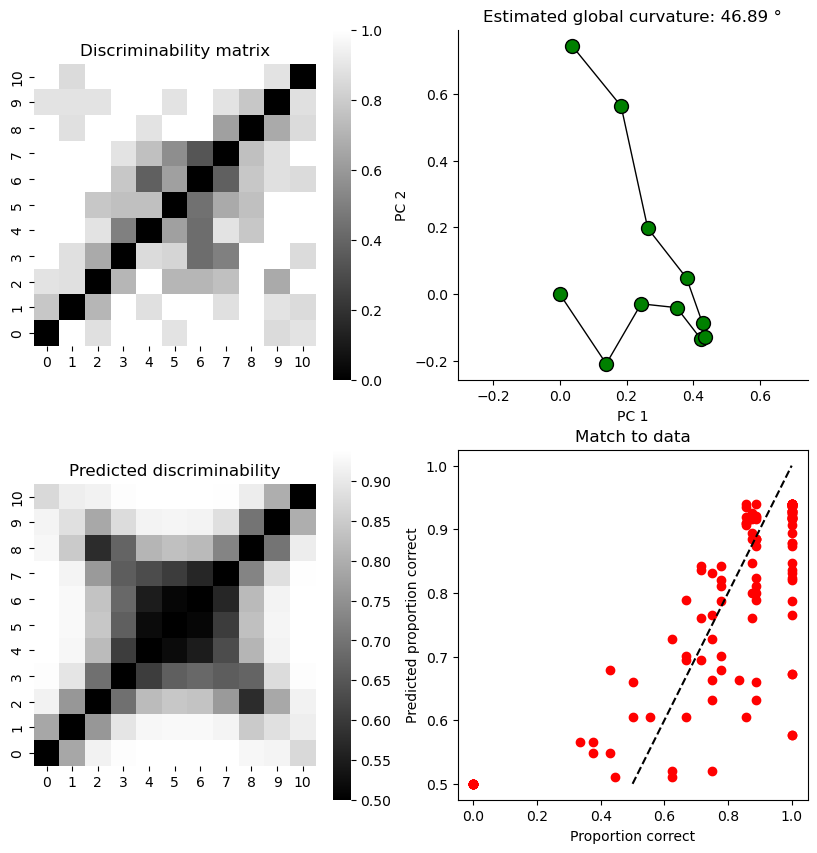

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(prob_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()